In [1]:
# original code from https://docs.scarches.org/en/latest/scvi_surgery_pipeline.html
# there is some difference between the above vignette and the one from 
# https://scarchest.readthedocs.io/en/latest/scvi_surgery_pipeline.html

In [2]:
import os
#os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

/groups/tanaka/People/current/jiwang/local/anaconda3/envs/scarches/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)


In [36]:
#url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
#output = 'pancreas.h5ad'
#gdown.download(url, output, quiet=False)
outDir = '/groups/tanaka/People/current/jiwang/projects/RA_competence/results/scRNAseq_R13547_10x_mNT_20220813/mapping_to_MouseGastrulationData/dataMapping_subsettingRef_mNT.noRA.RA.d2_d5_scVI/'

In [37]:
adata_all = sc.read(outDir + 'RNAmatrix_mouseGastrulation_mNT_HVG5k.h5ad') # input for only 2000HVGs

In [38]:
adata_all

AnnData object with n_obs × n_vars = 61925 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'dataset', 'stage', 'sequencing.batch', 'celltype', 'nCount_originalexp', 'nFeature_originalexp', 'cell', 'barcode', 'sample', 'pool', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'colour', 'sizeFactor'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [39]:
condition_key = 'dataset'
cell_type_key = 'celltype'
target_conditions = ['mNT']

In [40]:
#vae_epochs = 500
#surgery_epochs = 500

#early_stopping_kwargs = {
#    "early_stopping_metric": "elbo",
#    "save_best_state_metric": "elbo",
#    "patience": 10,
#    "threshold": 0,
#    "reduce_lr_on_plateau": True,
#    "lr_patience": 8,
#    "lr_factor": 0.1,
#}

In [41]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy() # source is the reference
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()


In [42]:
source_adata

AnnData object with n_obs × n_vars = 50925 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'dataset', 'stage', 'sequencing.batch', 'celltype', 'nCount_originalexp', 'nFeature_originalexp', 'cell', 'barcode', 'sample', 'pool', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'colour', 'sizeFactor'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [43]:
target_adata

AnnData object with n_obs × n_vars = 11000 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'condition', 'iscell_dd', 'cell.id', 'percent.mt', 'DF_out', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'celltypes', 'dataset', 'stage', 'sequencing.batch', 'celltype', 'nCount_originalexp', 'nFeature_originalexp', 'cell', 'barcode', 'sample', 'pool', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'colour', 'sizeFactor'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [44]:
sca.models.SCVI.setup_anndata(source_adata, batch_key=condition_key)

In [46]:
n_layers = 3
ref_path = outDir + 'ref_model_HGV5K_layersNN_' + str(n_layers)
ref_path

'/groups/tanaka/People/current/jiwang/projects/RA_competence/results/scRNAseq_R13547_10x_mNT_20220813/mapping_to_MouseGastrulationData/dataMapping_subsettingRef_mNT.noRA.RA.d2_d5_scVI/ref_model_HGV5K_layersNN_3'

In [47]:
vae = sca.models.SCVI(
    source_adata,
    n_layers= n_layers,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [48]:
vae.train()

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
INFO:lightning.pytorch.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 157/157: 100%|██████████| 157/157 [49:47<00:00, 17.58s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.13e+3]

INFO: `Trainer.fit` stopped: `max_epochs=157` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=157` reached.


Epoch 157/157: 100%|██████████| 157/157 [49:47<00:00, 19.03s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.13e+3]


In [49]:
vae.save(ref_path, overwrite=True)

In [50]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

In [51]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)


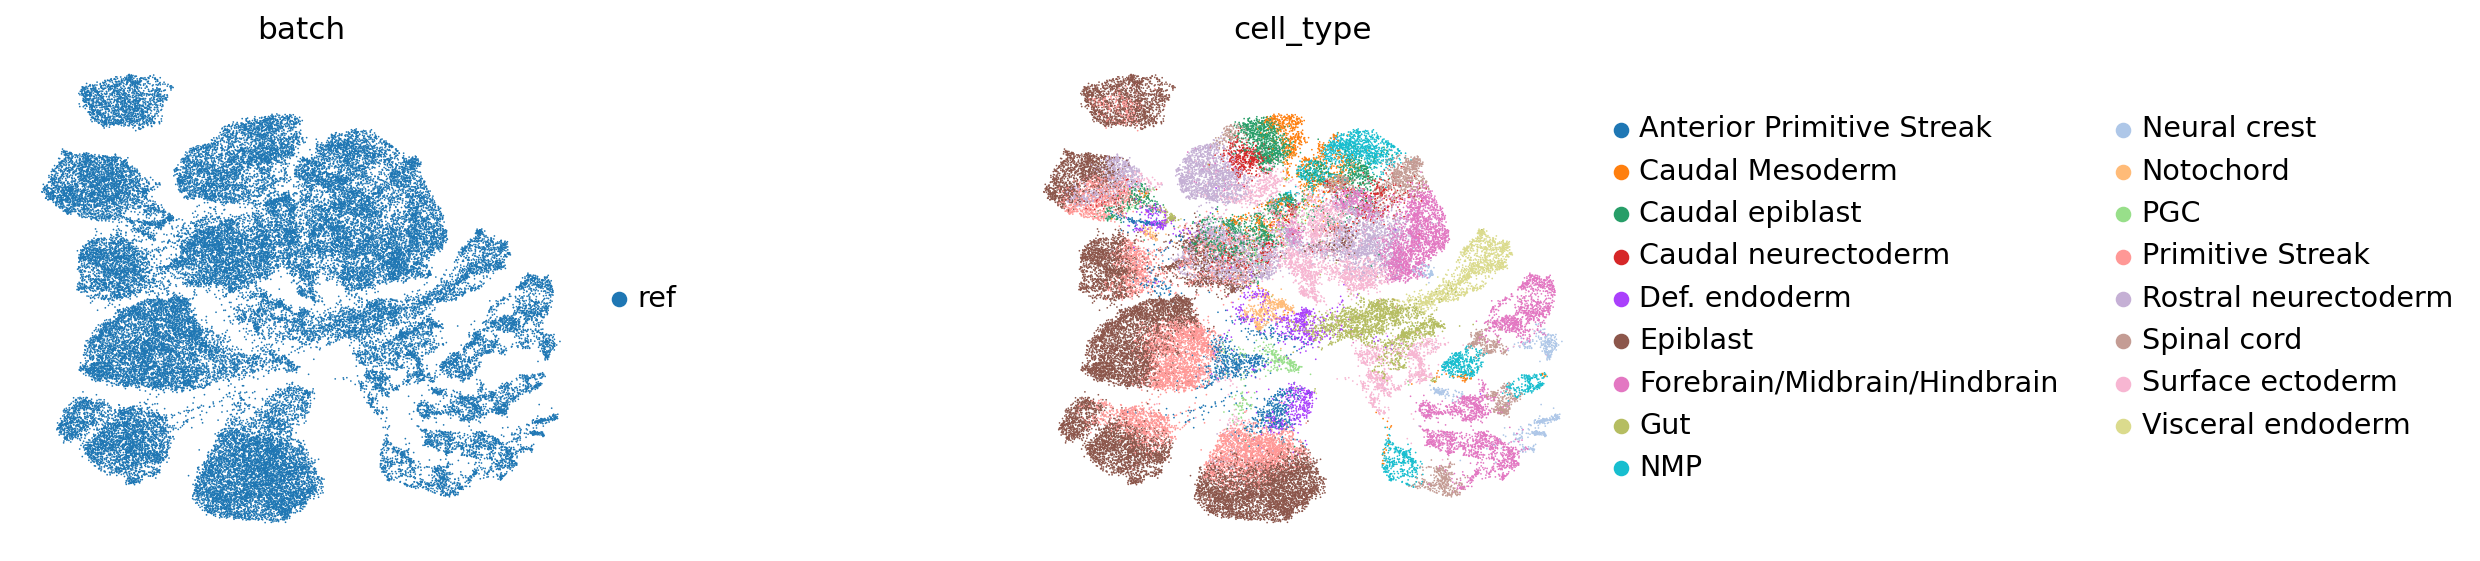

In [52]:
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )


In [53]:
# Perform surgery on reference model and train on query dataset

In [54]:
model = sca.models.SCVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)


INFO     File                                                                                                      
         /groups/tanaka/People/current/jiwang/projects/RA_competence/results/scRNAseq_R13547_10x_mNT_20220813/mappi
         ng_to_MouseGastrulationData/dataMapping_subsettingRef_mNT.noRA.RA.d2_d5_scVI/ref_model_HGV5K_layersNN_3/mo
         del.pt already downloaded                                                                                 


In [55]:
model.train(max_epochs=200, plan_kwargs=dict(weight_decay=0.0))
#model.train(n_epochs=surgery_epochs, 
#            frequency=1, 
#            early_stopping_kwargs=early_stopping_kwargs, 
#            weight_decay=0)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
INFO:lightning.pytorch.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 200/200: 100%|██████████| 200/200 [09:46<00:00,  3.15s/it, v_num=1, train_loss_step=4.35e+3, train_loss_epoch=4.41e+3]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [09:46<00:00,  2.93s/it, v_num=1, train_loss_step=4.35e+3, train_loss_epoch=4.41e+3]


In [56]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()


<Figure size 320x320 with 0 Axes>

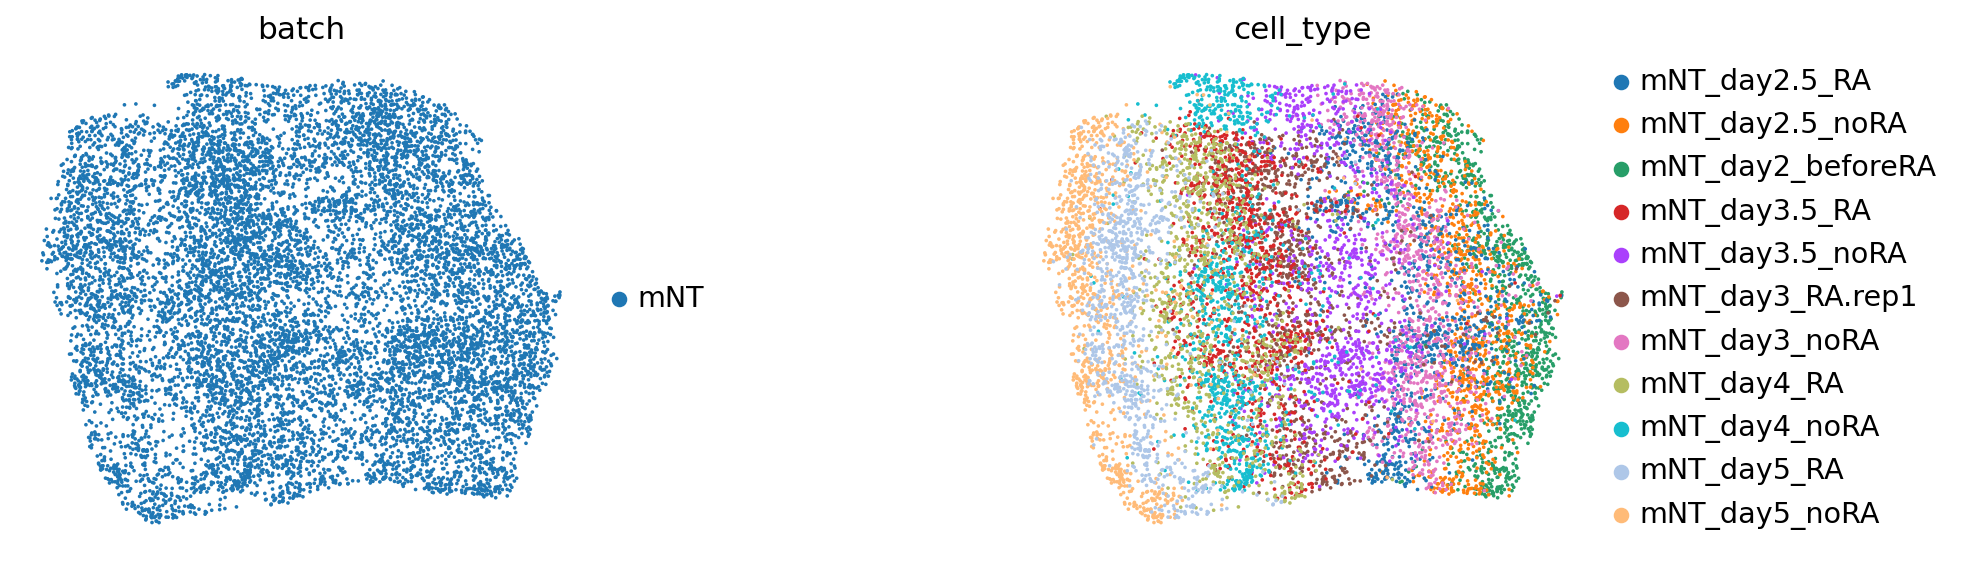

In [57]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

In [58]:
surgery_path = outDir + 'surgery_model/'
model.save(surgery_path, overwrite=True)

In [59]:
adata_full = source_adata.concatenate(target_adata)
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata_full.obs[condition_key].tolist()


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [60]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)


<Figure size 320x320 with 0 Axes>

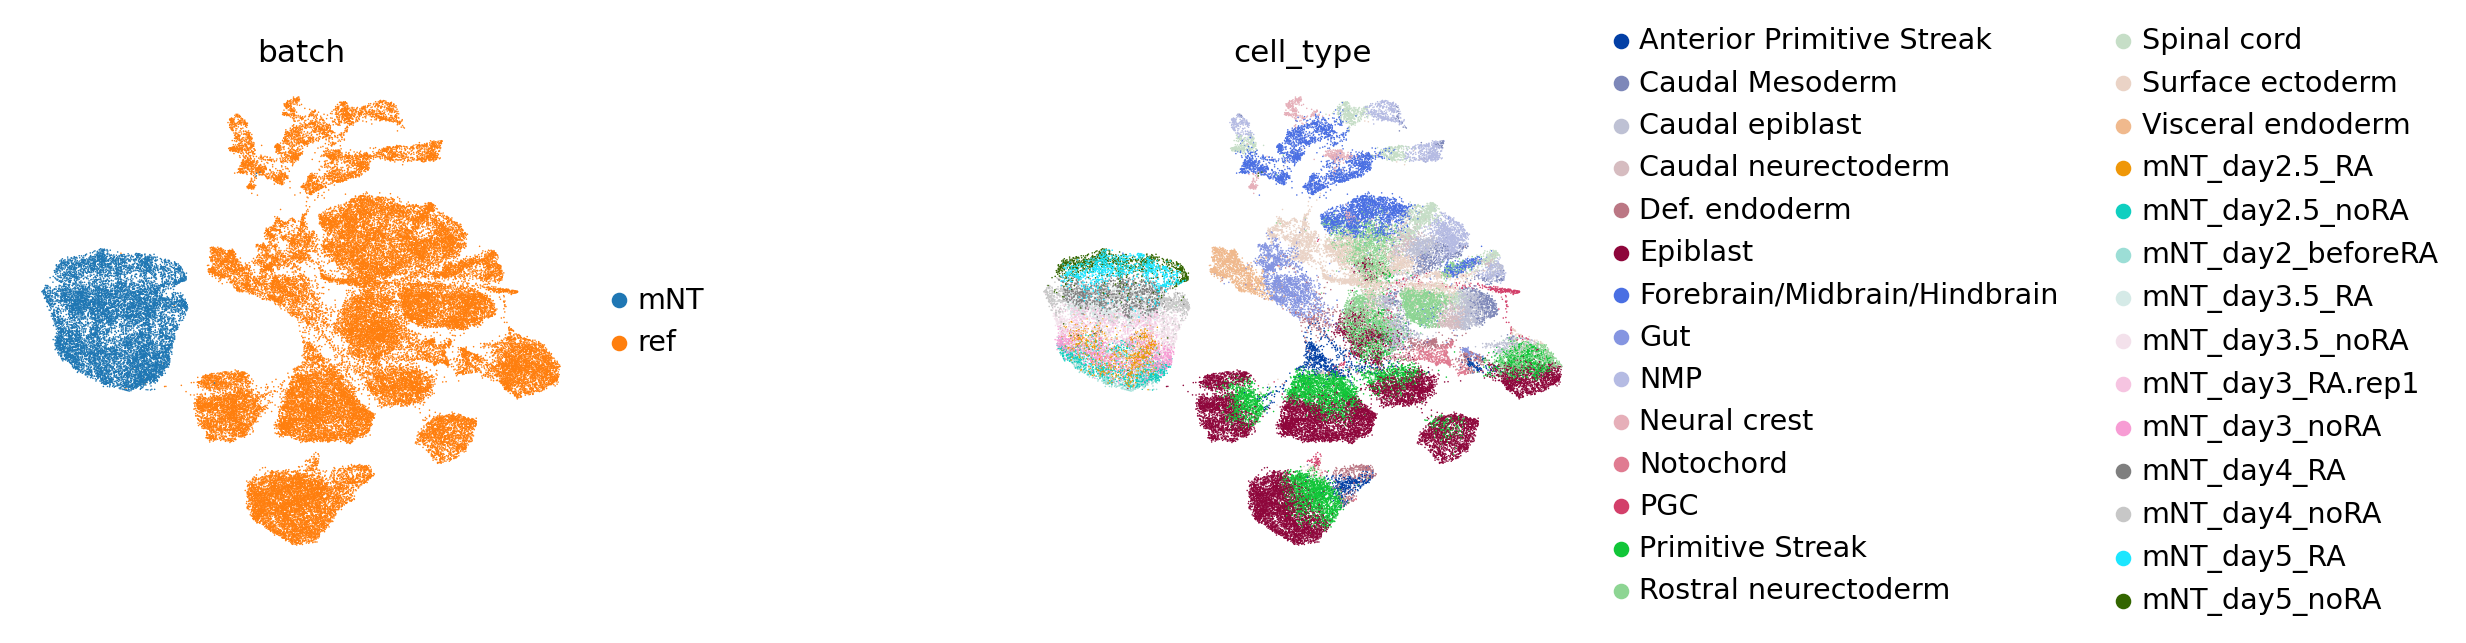

In [64]:
plt.figure()

sc.pl.umap(
    full_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
    save=os.path.join("dataIntegration_scVI.pdf")
)

#fig.savefig(os.path.join(outDir, "/dataIntegration_scVI.pdf")) 